# FINM 250 Homework 4
### TA Solutions

## Part 2 (Optional)

### 1

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../cmds")
from utils import (
    calc_univariate_regression,
    calc_iterative_regression,
    calc_performance_metrics,
    calc_performance_metrics
)


# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.family"] = "serif"
plt.style.use("ggplot")

# Pandas settings.
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

ADJ = 12

from functools import partial

get_data = partial(
    pd.read_excel, "../data/gmo_analysis_data.xlsx", index_col=0, parse_dates=[0]
)

signals = get_data(sheet_name="signals")
returns = get_data(sheet_name="returns (total)")
spy = returns[['SPY']]
risk_free = get_data(sheet_name="risk-free rate")

rets_2011 = returns.loc[:"2011"]
rets_2012 = returns.loc["2012":]

pd.concat(
    [
        calc_performance_metrics(rets_2011[["GMWAX"]]),
        calc_performance_metrics(rets_2012[["GMWAX"]]),
        calc_performance_metrics(returns[["GMWAX"]]),
    ],
    keys=["-2011", "2012-", "Full"],
).T

,-2011,2012-,Full
,GMWAX,GMWAX,GMWAX
Annualized Return,0.0445,0.0568,0.0499
Annualized Volatility,0.1245,0.0963,0.1128
Annualized Sharpe Ratio,0.3573,0.5898,0.4428
Annualized Sortino Ratio,0.4123,0.8451,0.5377
Skewness,-1.1468,-0.5088,-1.0049
Excess Kurtosis,3.0127,2.3523,3.1928
VaR (0.05),-0.0562,-0.0367,-0.0465
CVaR (0.05),-0.0936,-0.0578,-0.0811
Min,-0.1450,-0.1186,-0.1450


Yes, although not by much. In particular since 2012 the mean has increased from 4.45% to 5.68%, and the volatility has decreased from 12.45% to 9.63%. Consequently, the Sharpe ratio has increased from 0.36 to 0.59.

### 2

GMWAX performs okay by these stats. Its VaR and CVaR are moderate compared to other things we have seen in class, although a max drawdown of 35% is a little risky. Yes, it depends on the samples, all the tail risk measures look better in the 2012-present period.

### 3

In [2]:
pd.concat(
    [
        calc_univariate_regression(rets_2011["GMWAX"], rets_2011[["SPY"]]),
        calc_univariate_regression(rets_2012["GMWAX"], rets_2012[["SPY"]]),
        calc_univariate_regression(returns["GMWAX"], returns[["SPY"]]),
    ],
    keys=["-2011", "2012-", "Full"],
).T

,-2011,2012-,Full
,GMWAX,GMWAX,GMWAX
Alpha,0.0076,-0.0258,-0.0058
Beta,0.5372,0.5832,0.5527
Downside Beta,0.5789,0.5579,0.5719
R-Squared,0.5080,0.7557,0.5854
Treynor Ratio,0.0828,0.0974,0.0904
Information Ratio,0.0871,-0.5414,-0.0801
Tracking Error,0.0073,0.0040,0.0061


It is definitely NOT a lot-beta strategy. Both the beta and $r^2$ are quite high, meaning that it is correlated to the market. This has not changed since the case.

Alpha wise, it did provide alpha to the tune of 1% per year before 2011, but since then it has been negative. Across the full period it has a negative alpha and a negative information ratio.

## Part 3

### 1

In [3]:
signals_lag = signals.shift(1).dropna()
spy = spy.loc[signals_lag.index]

# Expanding.
forecast_df = spy.expanding().mean().shift(1).dropna()
forecast_df.columns = ['Mean']

# DP/EP regression.
dp_regr = sm.OLS(spy, sm.add_constant(signals_lag['DP'])).fit()
forecast_df['DP'] = dp_regr.params[0] + dp_regr.params[1] * signals['DP']
ep_regr = sm.OLS(spy, sm.add_constant(signals_lag['EP'])).fit()
forecast_df['EP'] = ep_regr.params[0] + ep_regr.params[1] * signals['EP']

print(f'DP Regression: Alpha: {dp_regr.params[0]:.4f}, Beta: {dp_regr.params[1]:.4f}, R^2: {dp_regr.rsquared:.4f}')
print(f'EP Regression: Alpha: {ep_regr.params[0]:.4f}, Beta: {ep_regr.params[1]:.4f}, R^2: {ep_regr.rsquared:.4f}')

# Multi-variate regression.
multi_regr = sm.OLS(spy, sm.add_constant(signals_lag)).fit()
forecast_df['Multi'] = multi_regr.params[0] + multi_regr.params[1] * signals['DP'] + multi_regr.params[2] * signals['EP'] + multi_regr.params[3] * signals['US10Y']

print('-'*50)
print('Multivariate Regression Summary')
display(multi_regr.params)
print(f'R^2: {multi_regr.rsquared:.4f}')

forecast_df.dropna(inplace=True)
forecast_df['Actuals'] = spy['SPY']
forecast_df['Risk-Free'] = risk_free['US3M']


DP Regression: Alpha: -0.0123, Beta: 0.0114, R^2: 0.0087
EP Regression: Alpha: -0.0032, Beta: 0.0026, R^2: 0.0050
--------------------------------------------------
Multivariate Regression Summary


const   -0.0146
DP       0.0091
EP       0.0021
US10Y   -0.0009
dtype: float64

R^2: 0.0133


### 2

In [4]:
forecast_wt = forecast_df * 100
forecast_model = forecast_wt[['DP', 'EP', 'Multi']]

forecast_model = forecast_model.multiply(forecast_df['Actuals'], axis=0)
forecast_model['Actuals'] = forecast_df['Actuals']

display(calc_performance_metrics(forecast_model).T)

# Calculate market stats.
calc_iterative_regression(forecast_model, forecast_model[['Actuals']], one_to_many=True).iloc[:-1, :]

,DP,EP,Multi,Actuals
Annualized Return,0.0723,0.0824,0.0779,0.0997
Annualized Volatility,0.1756,0.1284,0.1623,0.1560
Annualized Sharpe Ratio,0.4116,0.6421,0.4803,0.6390
Annualized Sortino Ratio,0.4034,0.8886,0.5025,0.9029
Skewness,-1.5089,-0.2201,-0.9334,-0.5267
Excess Kurtosis,14.1416,1.9890,7.3810,0.7313
VaR (0.05),-0.0644,-0.0604,-0.0735,-0.0782
CVaR (0.05),-0.1273,-0.0830,-0.1202,-0.0979
Min,-0.3522,-0.1257,-0.2760,-0.1652
Max,0.2387,0.1680,0.1991,0.1270


,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
DP,-0.0217,0.9431,1.2362,0.7017,0.0767,-0.2264,0.0080
EP,0.0086,0.7407,0.6751,0.8098,0.1113,0.1537,0.0047
Multi,-0.0072,0.8535,1.0344,0.6734,0.0913,-0.0772,0.0077


### 3

,DP,EP,Multi,Actuals,Risk-Free
Annualized Return,0.0051,0.0278,0.0193,0.0182,0.0231
Annualized Volatility,0.2221,0.1300,0.1820,0.1629,0.0058
Annualized Sharpe Ratio,0.0232,0.2137,0.1059,0.1115,3.9866
Annualized Sortino Ratio,0.0230,0.3176,0.1060,0.1567,NaN
Skewness,-1.3850,0.3499,-1.0151,-0.3898,0.5194
Excess Kurtosis,11.0167,3.2134,7.6461,0.6062,-1.1040
VaR (0.05),-0.0833,-0.0600,-0.0967,-0.0813,0.0000
CVaR (0.05),-0.1775,-0.0803,-0.1439,-0.1018,0.0000
Min,-0.3522,-0.1107,-0.2760,-0.1652,0.0000
Max,0.2387,0.1680,0.1991,0.1091,0.0053


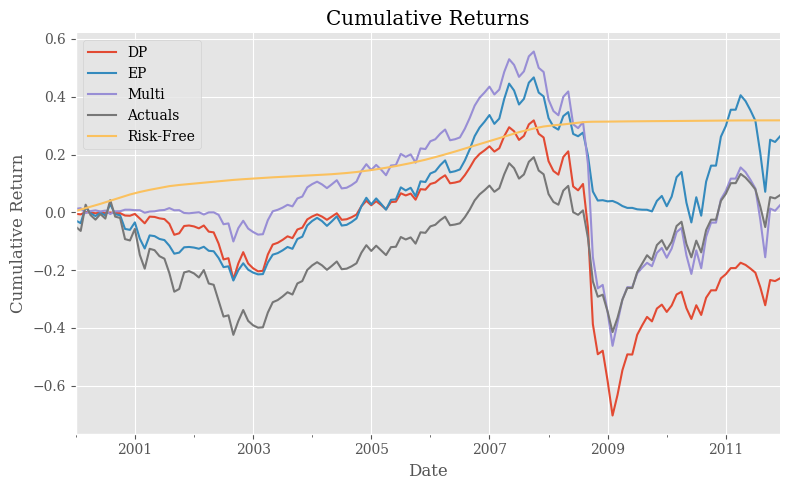

In [5]:
forecast_model['Risk-Free'] = forecast_df['Risk-Free']

forecast_subsample = forecast_model.loc['2000':'2011']
display(calc_performance_metrics(forecast_subsample).T)

fig, ax = plt.subplots(figsize=(8, 5))
forecast_subsample_cum = (forecast_subsample + 1).cumprod() - 1
forecast_subsample_cum.plot(ax=ax)

ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
fig.tight_layout()

Short term bonds outperform all by the earnings-to-price ratio. However, the comparison is also a little unfair given that we are including the 2008 financial crisis, prior to 2008, all strategies except for SPY either outperform or are on par/slightly below the cumulative return of 3-month T-bills.

### 4

In [6]:
# Count negative forecasted returns.
neg_count = (forecast_df < 0).sum().to_frame('Count')
neg_count['Percentage'] = neg_count / len(forecast_df)
neg_count

,Count,Percentage
Mean,1,0.0031
DP,0,0.0000
EP,8,0.0247
Multi,36,0.1111
Actuals,118,0.3642
Risk-Free,0,0.0000


### 5

In [7]:
# Check risk metrics for GMWAX.
display(calc_performance_metrics(returns[['GMWAX']]).T)
display(calc_univariate_regression(returns[['GMWAX']], returns[['SPY']]))

,GMWAX
Annualized Return,0.0499
Annualized Volatility,0.1128
Annualized Sharpe Ratio,0.4428
Annualized Sortino Ratio,0.5377
Skewness,-1.0049
Excess Kurtosis,3.1928
VaR (0.05),-0.0465
CVaR (0.05),-0.0811
Min,-0.1450
Max,0.0859


,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
GMWAX,-0.0058,0.5527,0.5719,0.5854,0.0904,-0.0801,0.0061


For $r^X$; yes. Given that for all of the models we tested, they have very high market betas. So they are just loading up on market risk (by construction), so they do have a worse Sharpe Ratio, higher kurtosis, and worse risk metrics overall. I would say the EP performs the best out of all of them. 

Looking at GMWAX, I don't think it is necessarily risk that makes it worse, but rather it is just worse than SPY across the board, though it has a better max drawdown. Finally, it has a somewhat high market beta, at 0.55.